In [68]:
# Carregar Bibliotecas
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_text

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split    
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

import pickle
import pickle as pk

In [2]:
# Carregar o dataset MNIST
digits = datasets.load_digits(n_class=10)

images=digits.images
targets=digits.target

#Redimensionar matrix
images=images.reshape(len(images),8*8)

X = digits.data
y = digits.target

# Criar nomes de características
n_pixels = X.shape[1]
feature_names = [f'pixel_{i}' for i in range(n_pixels)]

# Dividir o dataset em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2)

In [13]:
### DecisionTreeClassifier
#Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
#Precisão com os melhores parâmetros: 0.9763380758807589
#Acurácia: 98.33%

# Criar uma Decision Tree
# Configuração do DecisionTreeClassifier
modelo_clf_entropy = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

# Treinar a Decision Tree
modelo_clf_entropy.fit(X_train, y_train)

# Prever as classes para o conjunto de teste
y_pred_clf_entropy = modelo_clf_entropy.predict(X_test)


# Configuração do DecisionTreeClassifier
modelo_clf_gini = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

# Treinar a Decision Tree
modelo_clf_gini.fit(X_train, y_train)

# Prever as classes para o conjunto de teste
y_pred_clf_gini = modelo_clf_gini.predict(X_test)

In [4]:
###XGBOOST
#Parametros extraídos do Gridsearch
#Melhores parâmetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
#Precisão com os melhores parâmetros: 0.9672861014324429

# Configurar o classificador XGBOOST
xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100, 
    use_label_encoder=False, 
    eval_metric='mlogloss',
    colsample_bytree = 0.8,
    subsample= 0.8, 
    random_state=42
)

# Treinar o modelo usando GridSearchCV
xgb.fit(X_train, y_train)

# Prever as classes para o conjunto de teste com o melhor modelo encontrado
y_pred_xgb=xgb.predict(X_test)



/home/codespace/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:37:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [5]:
###RANDOM FOREST
#Parametros extraídos do Gridsearch
#Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
#Precisão com os melhores parâmetros: 0.9763380758807589

modelo_rf_entropy = RandomForestClassifier(
    n_estimators=300, 
    max_depth=None,
    max_features= 'sqrt', 
    criterion='entropy', 
    min_samples_leaf=1,
    min_samples_split= 2, 
    random_state=42
)

modelo_rf_entropy.fit(X_train, y_train)
y_pred_rf_entropy = modelo_rf_entropy.predict(X_test)



modelo_rf_gini = RandomForestClassifier(
    n_estimators=300, 
    max_depth=None,
    max_features= 'sqrt', 
    criterion='gini', 
    min_samples_leaf=1,
    min_samples_split= 2, 
    random_state=42
)

modelo_rf_gini.fit(X_train, y_train)
y_pred_rf_gini = modelo_rf_gini.predict(X_test)

In [61]:
# Função para avaliar os modelos e o melhor desempenho
def evaluate_models(models_dict):
    # Armazenar os resultados de todos os modelos
    results_summary = []

    for model_name, (model, y_test, y_pred) in models_dict.items():
        # Avaliar o modelo
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        # Armazenar os resultados para comparação
        results_summary.append({
            'model_name': model_name,
            'accuracy': accuracy,
            'classification_report': class_report,
            'conf_matrix': conf_matrix
        })

    # Ordenar os resultados por acurácia em ordem decrescente
    results_summary.sort(key=lambda x: x['accuracy'], reverse=True)

    # Selecionar o melhor modelo
    best_model = results_summary[0]
    best_model_name = best_model['model_name']
    best_accuracy = best_model['accuracy']

    # Imprimir o array de resultados com cabeçalhos e bordas
    print("#   | Modelo                    | Acurácia")
    print("----+---------------------------+---------")
    for i, result in enumerate(results_summary):
        ranking = i + 1
        model_name = result['model_name']
        accuracy = result['accuracy'] * 100.0
        print(f"{ranking:<4}| {model_name:<25} | {accuracy:.1f}%")
    print("----+---------------------------+---------")
    # Imprimir e visualizar os resultados dos modelos restantes
    for result in results_summary:
        model_name = result['model_name']
        print(f"\nResultados para {model_name}:")
        print("Accuracy: %.2f%%" % (result['accuracy'] * 100.0))
        print("Relatório de Classificação:")
        print(result['classification_report'])
        
        # Visualizar a Matriz de Confusão
        plt.figure(figsize=(4, 3))
        sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues', 
                    xticklabels=list(range(10)), yticklabels=list(range(10)))
        plt.title(f'Matriz de Confusão - {model_name}')
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

    return best_model_name, best_accuracy, results_summary


#   | Modelo                    | Acurácia
----+---------------------------+---------
1   | Random Forest - Gini      | 98.1%
2   | Random Forest - Entropy   | 97.5%
3   | XGBoost                   | 96.9%
4   | D.T.Classifier - Gini     | 81.9%
5   | D.T. Classifier - Entropy | 80.0%
----+---------------------------+---------

Resultados para Random Forest - Gini:
Accuracy: 98.06%
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      0.98      0.96        42
           2       1.00      1.00      1.00        36
           3       1.00      0.95      0.97        39
           4       0.97      1.00      0.98        30
           5       0.98      0.98      0.98        48
           6       0.98      0.98      0.98        46
           7       0.94      1.00      0.97        34
           8       1.00      0.92      0.96        26
           9       1.00      1.00      1.00   

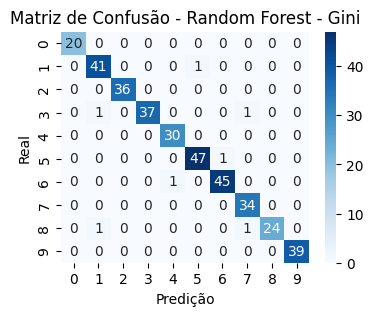


Resultados para Random Forest - Entropy:
Accuracy: 97.50%
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      0.98      0.96        42
           2       1.00      1.00      1.00        36
           3       1.00      0.92      0.96        39
           4       1.00      1.00      1.00        30
           5       0.96      0.98      0.97        48
           6       0.98      0.98      0.98        46
           7       0.94      1.00      0.97        34
           8       0.92      0.92      0.92        26
           9       1.00      0.97      0.99        39

    accuracy                           0.97       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.97      0.97       360



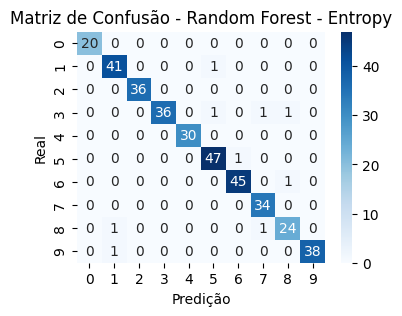


Resultados para XGBoost:
Accuracy: 96.94%
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.91      0.98      0.94        42
           2       1.00      1.00      1.00        36
           3       0.97      0.92      0.95        39
           4       0.97      0.97      0.97        30
           5       1.00      0.96      0.98        48
           6       0.94      0.96      0.95        46
           7       0.97      1.00      0.99        34
           8       0.96      0.96      0.96        26
           9       1.00      0.97      0.99        39

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



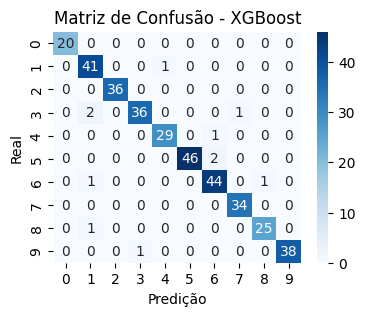


Resultados para D.T.Classifier - Gini:
Accuracy: 81.94%
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       0.83      0.71      0.77        42
           2       0.88      0.83      0.86        36
           3       0.84      0.82      0.83        39
           4       0.80      0.93      0.86        30
           5       0.86      0.75      0.80        48
           6       0.88      0.91      0.89        46
           7       0.91      0.91      0.91        34
           8       0.57      0.65      0.61        26
           9       0.72      0.74      0.73        39

    accuracy                           0.82       360
   macro avg       0.82      0.83      0.82       360
weighted avg       0.82      0.82      0.82       360



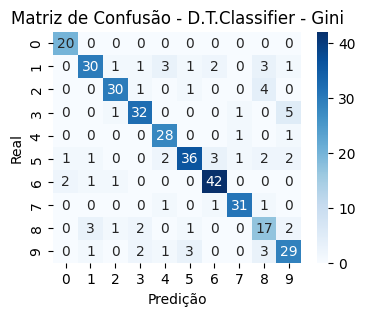


Resultados para D.T. Classifier - Entropy:
Accuracy: 80.00%
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84        20
           1       0.87      0.79      0.82        42
           2       0.89      0.89      0.89        36
           3       0.73      0.69      0.71        39
           4       0.79      0.77      0.78        30
           5       0.75      0.81      0.78        48
           6       0.89      0.85      0.87        46
           7       0.94      0.88      0.91        34
           8       0.67      0.69      0.68        26
           9       0.70      0.72      0.71        39

    accuracy                           0.80       360
   macro avg       0.80      0.80      0.80       360
weighted avg       0.80      0.80      0.80       360



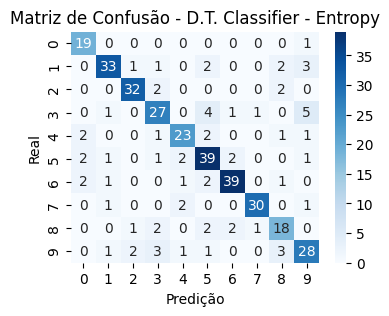

In [62]:
#################
#Avaliar Modelos
#################

models_dict = {
    "D.T. Classifier - Entropy": (modelo_clf_entropy, y_test, y_pred_clf_entropy),
    "D.T.Classifier - Gini": (modelo_clf_gini, y_test, y_pred_clf_gini),
    "XGBoost": (xgb, y_test, y_pred_xgb),
    "Random Forest - Entropy": (modelo_rf_entropy, y_test, y_pred_rf_entropy),
    "Random Forest - Gini": (modelo_rf_gini, y_test, y_pred_rf_gini),
}

best_model_name, best_accuracy, results_summary = evaluate_models(models_dict)

In [69]:
#Salva o Melhor Modelo serializado
#model = pk.load(open('model_clf.sav', 'rb'))

with open('model_clf.sav', 'wb') as file:
    pickle.dump(best_model_name, file)